# RCS analysis and paper plots

In [1]:
from analysis_functions import *
from plotting_functions import *
from data_loading_functions import *

Define all the pairs of qubit number N and depth d that are explored in the data:

In [2]:
Nd_pairs_xeb = [(16,12),(24,12),(32,12),(40,12),(48,12),(56,8),(56,10),(56,12),(56,14),(56,16),(56,18),(56,20)]
Nd_pairs_t1qrb = [(N,d) for N in [16,24,32,40,48,56] for d in [4,16,32,48,64,96]]
Nd_pairs_mb = [(16,12),(24,12),(32,12),(40,12),(48,12),(56,8),(56,10),(56,12),(56,14),(56,16),(56,18),(56,20),(56,24)]
Nd_pairs_xeb_N40_verification = [(40,8),(40,10),(40,12),(40,14),(40,16),(40,18),(40,20)]
Nd_pairs_t1qrb_N40_verification = [(40,d) for d in [4,16,32,48,64,96]]
Nd_pairs_mb_N40_verification = [(40,8),(40,10),(40,12),(40,14),(40,16),(40,18),(40,20)]

Define parameters of H2 (see system_benchmarking, and Table I in arXiv:2406.XXXXX) and other parameters for analysis and plotting.

In [3]:
spam_uncert = 9e-5
spam_fid = 1 - 1.47e-3
tq_uncert = 5e-5
tq_fid = 1 - 1.57e-3

eff_tq_depth_shift = 1.117519963783798
n_resamples = 1000
t1qrb_seq_lengths = [4,16,32,48,64,96]
t1qrb_seq_lengths_interp = np.arange(0,100,.1)
Nrange = [16,24,32,40,48,56]
Nrange_interp = np.arange(16,56,.01)
drange = list(range(8,22,2))
drange_interp = np.arange(8,20,.01)

## Calculating $F_{XEB}$ of random circuits

To calculate $F_{XEB}$, first load the amplitudes and measurement counts from the corresponding JSON files, and compute the probabilities of each bitstring from the amplitudes. With the amplitudes and measurement counts from each circuit, one computes $F_{XEB}$ and its uncertainty.

In [4]:
xeb, xeb_uncertainties = load_XEB_results(Nd_pairs_xeb, n_resamples)
xeb_N40_verification, xeb_uncertainties_N40_verification = load_XEB_results_N40_verification(Nd_pairs_xeb_N40_verification, n_resamples)
print('F_{XEB} for Depth-12 experiment results:')
print({(N,d):xeb[(N,d)] for (N,d) in Nd_pairs_xeb if N <=40})
print('F_{XEB} for N=40 verification experiment results:')
print({(N,d):xeb_N40_verification[(N,d)] for (N,d) in Nd_pairs_xeb_N40_verification})

F_{XEB} for Depth-12 experiment results:
{(16, 12): 0.7996194809368216, (24, 12): 0.66328428858555, (32, 12): 0.5644693601236068, (40, 12): 0.4260097944481408}
F_{XEB} for N=40 verification experiment results:
{(40, 8): 0.6317206938771034, (40, 10): 0.45022974436541163, (40, 12): 0.4568927431440281, (40, 14): 0.3971826245738921, (40, 16): 0.3680538667471604, (40, 18): 0.2661268834768433, (40, 20): 0.3019997346749341}


## Calculating $F_{MB}$ from mirror benchmarking circuits

As before, we load the measurement results from the corresponding JSON files along with the expected ideal bitstrings, in order to compute $F_{MB}$ and its uncertainty.

In [5]:
mb_fidelity, mb_uncertainties = load_MB_results(Nd_pairs_mb, n_resamples)
mb_fidelity_N40_verification, mb_uncertainties_N40_verification = load_MB_results_N40_verification(Nd_pairs_mb_N40_verification, n_resamples)
print('F_{MB} for Depth-12 experiment and N=56 experiment results:')
print({(N,d):mb_fidelity[(N,d)] for (N,d) in Nd_pairs_mb})
print('F_{MB} for N=40 verification experiment results:')
print({(N,d):mb_fidelity_N40_verification[(N,d)] for (N,d) in Nd_pairs_mb_N40_verification})

F_{MB} for Depth-12 experiment and N=56 experiment results:
{(16, 12): 0.784, (24, 12): 0.65, (32, 12): 0.576, (40, 12): 0.501, (48, 12): 0.413, (56, 8): 0.489, (56, 10): 0.409, (56, 12): 0.387, (56, 14): 0.287, (56, 16): 0.248, (56, 18): 0.206, (56, 20): 0.172, (56, 24): 0.1208}
F_{MB} for N=40 verification experiment results:
{(40, 8): 0.6, (40, 10): 0.518, (40, 12): 0.476, (40, 14): 0.374, (40, 16): 0.305, (40, 18): 0.289, (40, 20): 0.261}


## Calculating $\epsilon_{\rm mem} (N)$ from Transport 1Q RB

We use the transport 1Q RB data to determine the average survival of each qubit's state after idling during the transport and cooling that it would experience in RCS circuits, without any of the 2Q gate errors. From fits of an exponential decay curve to the average survival as a function of sequence length, we determine $\epsilon_{\rm mem} (N)$.

In [6]:
t1qrb_survival, t1qrb_uncertainties = load_t1qrb_results(Nd_pairs_t1qrb, n_resamples, t1qrb_seq_lengths)
t1qrb_survival_N40_verification, t1qrb_uncertainties_N40_verification = load_t1qrb_results_N40_verification(Nd_pairs_t1qrb_N40_verification, n_resamples, t1qrb_seq_lengths)
print('Memory error per qubit per layer as a function of N:')
print({N:1-t1qrb_uncertainties[N][1][0] for N in Nrange})
print('Memory error per qubit per layer for N=40 verification experiment:')
print({40:1-t1qrb_uncertainties_N40_verification[40][1][0]})

Memory error per qubit per layer as a function of N:
{16: 0.00015295587559105428, 24: 0.00025051180929480665, 32: 0.0004192781121177269, 40: 0.0004094080888772389, 48: 0.00040992186542032627, 56: 0.00039673559380992707}
Memory error per qubit per layer for N=40 verification experiment:
{40: 0.00046328211179536005}


Below, we plot the average survival of the transport 1Q RB circuits as a function of sequence length for the different $N$ explored in the experiment.

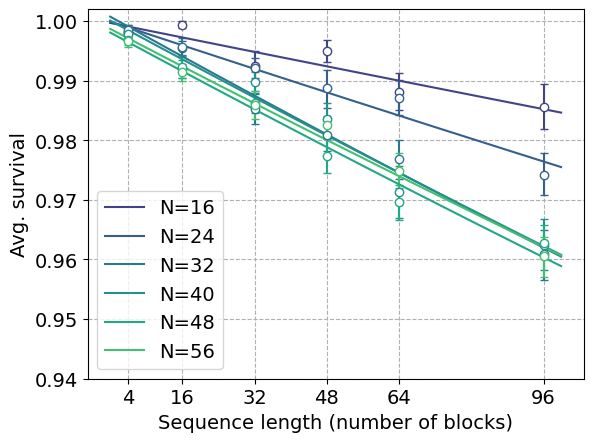

In [7]:
plot_t1qrb_survival_curves(t1qrb_survival, t1qrb_uncertainties, t1qrb_seq_lengths, t1qrb_seq_lengths_interp, Nrange)

We also plot the average survival for the transport 1Q RB experiment interleaved with the $N=40$ verification circuits.

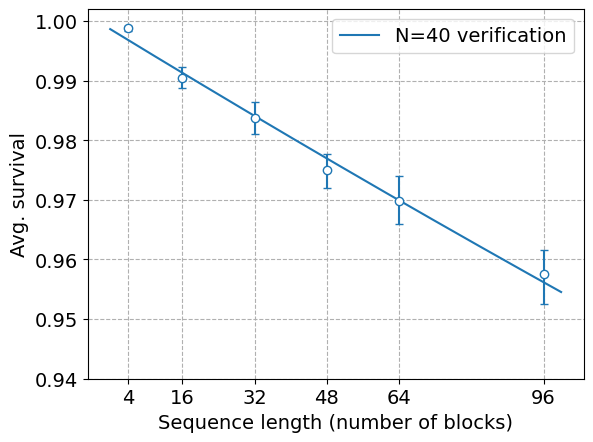

In [8]:
plot_t1qrb_survival_curve_N40_verification(t1qrb_survival_N40_verification, t1qrb_uncertainties_N40_verification, t1qrb_seq_lengths, t1qrb_seq_lengths_interp)

Finally, from the various decay curves, we plot $\epsilon_{\rm mem} (N)$ and its empirical logistic function model .

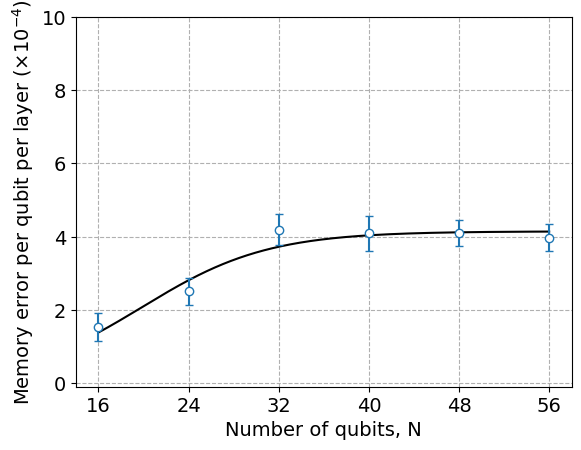

In [9]:
popt, perrs, mem_errs, mem_err_uncerts = plot_mem_error_and_logistic(t1qrb_uncertainties, Nrange, Nrange_interp)

From the logistic function model for $\epsilon_{\rm mem} (N)$ and the measured average 2Q fidelity, we can extract the effective fidelity per 2Q gate. Using this, we calculate estimates of the fidelity according to the "gate counting" model.

In [10]:
gc_depth12 = [gate_counting(N,12,effective_2Q(tq_fid, mem_err(N, popt)), spam_fid, eff_tq_depth_shift) for N in Nrange_interp]
gc_depth12_uncerts = gate_counting_uncert_Nscan(tq_fid, tq_uncert, spam_fid, spam_uncert, eff_tq_depth_shift, popt, perrs, gc_depth12, Nrange_interp)
gc_depth12_lower = [gc_depth12[i] - gc_depth12_uncerts[i] for i in range(len(gc_depth12))]
gc_depth12_upper = [gc_depth12[i] + gc_depth12_uncerts[i] for i in range(len(gc_depth12))]

## Plotting fidelity estimates from mirror benchmarking, XEB, and gate counting

With the estimates of fidelity from gate counting in hand, we plot it alongside the estimates of fidelity from XEB and mirror benchmarking data computed above.

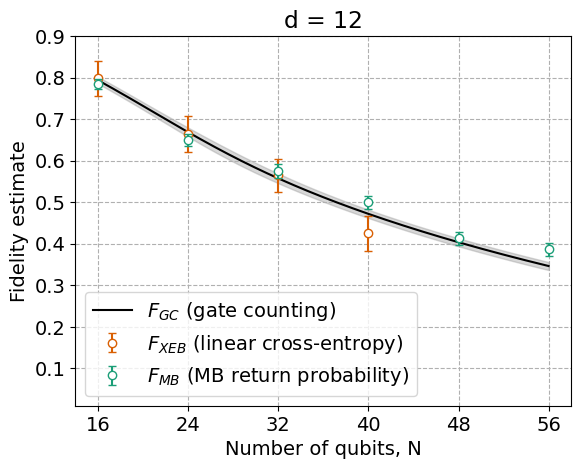

In [11]:
plot_depth12_data(xeb, xeb_uncertainties, mb_fidelity, mb_uncertainties, gc_depth12, gc_depth12_lower, gc_depth12_upper, Nrange, Nrange_interp)

At $N=56$ qubits we generate estimates of the fidelity according to gate counting using the exact memory error and its uncertainty measured at $N=56$, rather than the logistic function model. Then, we plot these estimates of fidelity along with our estimates from mirror benchmarking.

In [12]:
gc_N56 = [gate_counting(56,d,effective_2Q(tq_fid, mem_errs[-1]), spam_fid, eff_tq_depth_shift) for d in drange_interp]
gc_N56_uncerts = gate_counting_uncert_dscan(tq_fid, tq_uncert, spam_fid, spam_uncert, eff_tq_depth_shift, mem_errs[-1], mem_err_uncerts[-1], 56, gc_N56, drange_interp)
gc_N56_lower = [gc_N56[i] - gc_N56_uncerts[i] for i in range(len(gc_N56))]
gc_N56_upper = [gc_N56[i] + gc_N56_uncerts[i] for i in range(len(gc_N56))]

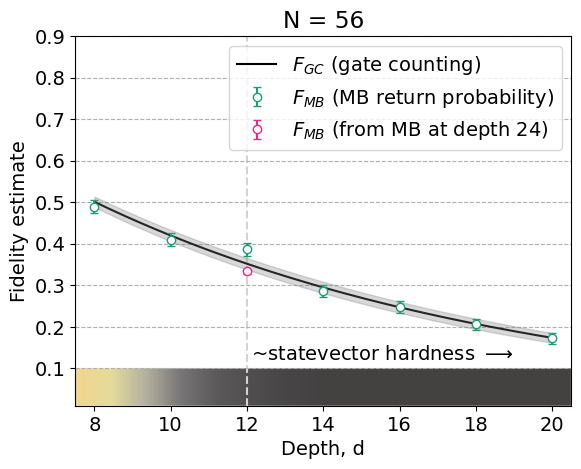

In [13]:
plot_N56_data(mb_fidelity, mb_uncertainties, gc_N56, gc_N56_lower, gc_N56_upper, spam_fid, spam_uncert, drange, drange_interp)

Finally, we produce gate-counting fidelity estimates from the measured memory error at $N=40$ for the verification data set, and plot it alongside the verified XEB and fidelity estimate from mirror benchmarking.

In [14]:
mem_err_N40 = 1-t1qrb_uncertainties_N40_verification[40][1][0]
mem_uncert_N40 = t1qrb_uncertainties[40][1][1]
gc_N40 = [gate_counting(40,d,effective_2Q(tq_fid, mem_err_N40), spam_fid, eff_tq_depth_shift) for d in drange_interp]
gc_N40_uncerts = gate_counting_uncert_dscan(tq_fid, tq_uncert, spam_fid, spam_uncert, eff_tq_depth_shift, mem_err_N40, mem_uncert_N40, 40, gc_N40, drange_interp)
gc_N40_lower = [gc_N40[i] - gc_N40_uncerts[i] for i in range(len(gc_N40))]
gc_N40_upper = [gc_N40[i] + gc_N40_uncerts[i] for i in range(len(gc_N40))]

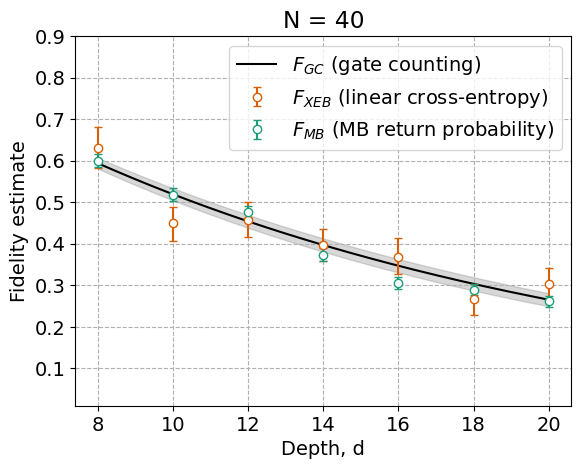

In [15]:
plot_N40_data(xeb_N40_verification, xeb_uncertainties_N40_verification, mb_fidelity_N40_verification, mb_uncertainties_N40_verification, gc_N40, gc_N40_lower, gc_N40_upper, drange, drange_interp)

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>